In [2]:
#pip install deepparse

Defaulting to user installation because normal site-packages is not writeable
  Using cached deepparse-0.9.8-py3-none-any.whl (217 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 5.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 51.9 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 7.4 MB/s eta 0:00:00m eta 0:00:010:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 71.9 MB/s eta 0:00:00

In [3]:
from deepparse.parser import AddressParser

In [4]:
address_parser = AddressParser(model_type='bpemb')

/home/daniel/.local/lib/python3.11/site-packages/deepparse/network/seq2seq.py:102: UserWarning: No pre-trained model where found in the cache directory /home/daniel/.cache/deepparse. Thus, we willautomatically download the pre-trained model.
  warnings.warn(


Loading the embeddings model
downloading https://nlp.h-its.org/bpemb/multi/multi.wiki.bpe.vs100000.model


100%|██████████| 1965223/1965223 [00:01<00:00, 1558147.03B/s]


downloading https://nlp.h-its.org/bpemb/multi/multi.wiki.bpe.vs100000.d300.w2v.bin.tar.gz


100%|██████████| 112202964/112202964 [00:10<00:00, 11143200.55B/s]


In [19]:
import numpy as np
import pandas as pd 
df = pd.read_csv('data/addresses_and_tweets.csv')
df = df.drop_duplicates(subset='text').reset_index(drop=True)

def balance_classes(df, column_name):
    """Balance the classes of a binary column in a dataframe."""
    counts = df[column_name].value_counts()
    # Check if classes are already balanced
    if counts.min() == counts.max():
        return df
    # Identify majority and minority classes
    majority_class = counts.idxmax()
    minority_class = counts.idxmin()
    # Randomly select instances from majority class to remove
    majority_indices = df[df[column_name] == majority_class].index
    num_instances_to_remove = len(majority_indices) - counts[minority_class]
    indices_to_remove = np.random.choice(majority_indices, size=num_instances_to_remove, replace=False)
    # Remove instances from majority class
    df = df.drop(indices_to_remove)
    return df.reset_index(drop=True)

df = balance_classes(df, 'is_address').sample(10000)[['text', 'is_address']]
df.is_address.value_counts()


0    5021
1    4979
Name: is_address, dtype: int64

In [20]:
df

,text,is_address
697501,"@colezz hahaa, im looking forward to the end o...",0
69092,@randz10 word. i miss joella's classes.,0
1368085,37 bowdoin street 43 02114,1
792191,11 bear ct,1
364712,@daviexxjonas davie!!!! i missed you glad you...,0
...,...,...
1507266,73 wellington hill street 1 02126,1
273914,now i need some xrays i guess it wasn't my kid...,0
384512,@entrepreneurgal i know i wish i could find a ...,0
461386,@dragonflyeyes added!,0


In [35]:
def func_is_address(parsed: dict):
    street_number = parsed.get('StreetNumber')
    street_name   = parsed.get('StreetName')
    postal_code   = parsed.get('PostalCode')    

    if (not street_name) or (not street_number) or (not postal_code):
        return False
    return True

def process(text: str):
    parsed = address_parser(text)
    is_address = func_is_address(parsed=parsed.to_dict())
    return is_address

df['prediction'] = df['text'].apply(process)


In [40]:
df['prediction'] = df['prediction'].astype(int)


In [41]:
df

,text,is_address,prediction
697501,"@colezz hahaa, im looking forward to the end o...",0,0
69092,@randz10 word. i miss joella's classes.,0,0
1368085,37 bowdoin street 43 02114,1,1
792191,11 bear ct,1,0
364712,@daviexxjonas davie!!!! i missed you glad you...,0,0
...,...,...,...
1507266,73 wellington hill street 1 02126,1,1
273914,now i need some xrays i guess it wasn't my kid...,0,0
384512,@entrepreneurgal i know i wish i could find a ...,0,0
461386,@dragonflyeyes added!,0,0


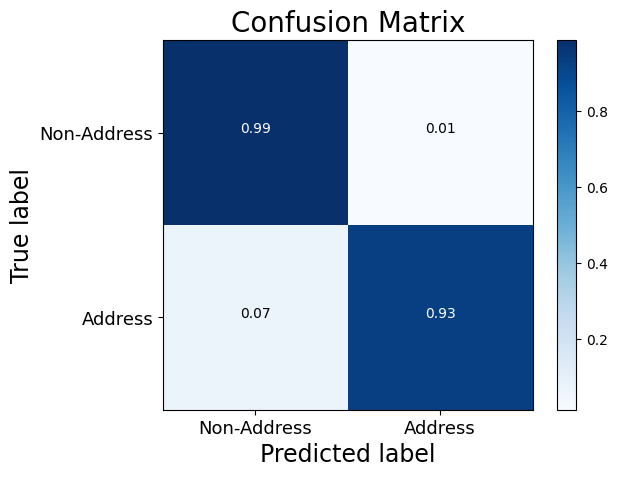

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
y_true = df['is_address']
y_pred = df['prediction']
cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)


class_names = ['Non-Address', 'Address']
plot_confusion_matrix(cm, classes=class_names, title="Confusion Matrix")
plt.show()
